In [ ]:
'''
If there's an error with yfinance, uncomment the lines below to uninstall and reinstall. This should fix most API-related errors such as rate-limiting.

'''

#pip uninstall yfinance
#pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 9.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors

In [ ]:
def preprocess_data(ticker, start_date, end_date, n_past=13, n_lookahead=13):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    close_prices = stock_data['Close'].values

    X, y = [], []
    for i in range(len(close_prices) - n_past - n_lookahead + 1):
        X.append(close_prices[i:i + n_past])
        y.append(close_prices[i + n_past + n_lookahead - 1])

    return np.array(X), np.array(y)

In [ ]:
def compute_memberships(X, a, b):
    # Expand `a` and `b` to match the number of samples in `X`
    a = a.unsqueeze(1)
    b = b.unsqueeze(1)

    # Compute the distance
    distance = torch.sum(a * X.unsqueeze(2), dim=-1) + b

    # Compute softmax for memberships
    memberships = F.softmax(-distance, dim=-1)

    return memberships

In [ ]:
class LearnableMembership(nn.Module):
    def __init__(self, input_dim, n_clusters):
        super(LearnableMembership, self).__init__()
        self.centers = nn.Parameter(torch.randn(n_clusters, input_dim))
        self.sigmas = nn.Parameter(torch.ones(n_clusters))

    def forward(self, x):
        diff = x.unsqueeze(2) - self.centers
        memberships = torch.exp(-torch.sum(diff**2, dim=-1) / (2 * self.sigmas**2))  # Gaussian formula
        return memberships

In [ ]:
def plot_k_distance(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, k-1])  # Distance to k-th nearest neighbor
    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.title(f'{k}-Distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}th Nearest Neighbor Distance')
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def fuzzy_clustering_dbscan(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)

    cluster_centers = []
    cluster_variances = []  # Track cluster variance for compactness
    noise_points = np.sum(cluster_labels == -1)  # Count noise points

    unique_labels = np.unique(cluster_labels[cluster_labels >= 0])  # Ignore noise (-1)

    for label in unique_labels:
        cluster_points = X[cluster_labels == label]
        center = cluster_points.mean(axis=0)
        variance = np.var(cluster_points, axis=0).mean()  # Compute variance

        cluster_centers.append(center)
        cluster_variances.append(variance)

    cluster_centers = np.array(cluster_centers)

    # Compute cluster compactness
    cluster_compactness = np.mean(cluster_variances) if cluster_variances else None

    # Compute cluster separation
    if len(cluster_centers) > 1:
        cluster_separation = np.mean([np.linalg.norm(c1 - c2)
                                      for i, c1 in enumerate(cluster_centers)
                                      for c2 in cluster_centers[i+1:]])
    else:
        cluster_separation = None

    noise_ratio = noise_points / len(X)

    return cluster_labels, cluster_centers, cluster_compactness, cluster_separation, noise_ratio


def gaussian_membership(x, center, sigma=1.0):
    return np.exp(-np.square(x - center) / (2 * sigma**2))


def defuzzify(cluster_labels, cluster_centers, n_samples):
    reconstructed = np.full(n_samples, np.nan)

    for i, label in enumerate(cluster_labels):
        if label >= 0:  # If not noise point
            reconstructed[i] = cluster_centers[label]

    return reconstructed


def evaluate_clustering(X, reconstructed):
    mask = ~np.isnan(reconstructed)  # Ignore noise points
    if np.sum(mask) == 0:
        return None, None  # If all points are noise, return None

    X_valid = X[mask]
    reconstructed_valid = reconstructed[mask]

    rmse = np.sqrt(mean_squared_error(X_valid, reconstructed_valid))
    r2 = r2_score(X_valid, reconstructed_valid)

    return rmse, r2

In [ ]:
'''For the section below, uncomment the RNN code and comment out the LSTM code to change the model to RNN-TSK. Results are comparable'''
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_clusters):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.n_clusters = n_clusters
        #self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, nonlinearity='relu')
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=3)
        self.fc_a = nn.Linear(hidden_dim, n_clusters * input_dim)  # a coefficients for each rule
        self.fc_b = nn.Linear(hidden_dim, n_clusters)              # b coefficients for each rule
        self.fc_c = nn.Linear(hidden_dim, n_clusters)              # c coefficients for each rule
        self.membership = LearnableMembership(input_dim, n_clusters)  # Learnable membership layer

    def forward(self, x):
        # RNN output
        #rnn_out, _ = self.rnn(x)
        #last_out = rnn_out[:, -1, :]  # Use the last timestep's output

        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]

        # TSK parameters
        a = torch.sigmoid(self.fc_a(last_out)).view(-1, self.n_clusters, self.input_dim)  # Keep between 0 and 1
        b = torch.sigmoid(self.fc_b(last_out)).view(-1, self.n_clusters)
        c = torch.sigmoid(self.fc_c(last_out)).view(-1, self.n_clusters)

        # Membership computation
        memberships = self.membership(x)

        return a, b, c, memberships

# TSK Layer
def tsk_layer(X, memberships, a, b, c):
    # Apply the fuzzy membership functions and calculate the TSK consequent
    if X.dim() == 2:
        X = X.unsqueeze(-1)

    batch_size, num_samples, input_dim = X.shape
    n_clusters = memberships.shape[-1]

    # Expand X to match the clusters' dimension
    X = X.unsqueeze(2)
    a = a.unsqueeze(1)
    b = b.unsqueeze(1)
    c = c.unsqueeze(1)

    # Compute the rule outputs
    rule_outputs = torch.sum(a * X, dim=-1) + b + c

    # Combine rule outputs using memberships
    weighted_outputs = memberships * rule_outputs

    membership_sums = torch.sum(memberships, dim=-1, keepdim=True) + 1e-6
    normalized_weights = memberships / membership_sums
    final_output = torch.sum(normalized_weights * rule_outputs, dim=-1).unsqueeze(-1)

    return final_output

In [ ]:
def train_model(X_train, y_train, X_test, y_test, eps=0.5, min_samples=5, epochs=100, lr=0.001):
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Standardize the flattened data for DBSCAN
    scaler = StandardScaler()
    n_samples, time_steps, n_features = X_train.shape
    X_train_flat = X_train.view(n_samples, -1).numpy()
    X_train_flat = scaler.fit_transform(X_train_flat)

    # Clustering using DBSCAN
    cluster_labels, cluster_centers, cluster_compactness, cluster_separation, noise_ratio = fuzzy_clustering_dbscan(X_train_flat, eps, min_samples)
    plot_k_distance(X_train_flat, 4)
    print(f"Cluster Compactness: {cluster_compactness}")
    print(f"Cluster Separation: {cluster_separation}")
    print(f"Noise Ratio: {noise_ratio}")

    if len(cluster_centers) == 0:
        print("DBSCAN found no clusters. Try adjusting eps or min_samples.")
        return None

    n_clusters = len(cluster_centers)
    print(f"DBSCAN found {n_clusters} clusters.")

    # Reshape the data back to 3D for RNN/LSTM input
    X_train = X_train.view(n_samples, time_steps, n_features)

    # Build RNN model
    model = RNNModel(input_dim=n_features, hidden_dim=64, n_clusters=n_clusters)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-5)
    loss_fn = nn.MSELoss()

    # Calculate fuzzy memberships for training
    memberships = np.array([gaussian_membership(X_train_flat, center) for center in cluster_centers]).T

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True)

    # Training loop
    for epoch in range(epochs):

      model.train()
      epoch_loss = 0

      for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        a, b, c, memberships = model(X_batch)

        # Compute memberships
        memberships = compute_memberships(X_batch, a, b)

        if memberships.shape[0] != X_batch.shape[0]:
            memberships = memberships[:X_batch.shape[0], ...]

        # Compute final predictions
        predictions = tsk_layer(X_batch, memberships, a, b, c)

        if predictions.ndim == 3:
            predictions = predictions[:, -1, :]  # Keep the last time step

        # Compute loss
        loss = loss_fn(predictions, y_batch)
        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

      '''print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    print("a values:", a.detach().cpu().numpy())
    print("b values:", b.detach().cpu().numpy())
    print("c values:", c.detach().cpu().numpy())'''

    eval_dataset = TensorDataset(X_test, y_test)
    eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, drop_last = True)

    # Testing
    model.eval()
    all_predictions = []

    with torch.no_grad():
      for X_eval, _ in eval_loader:
        a, b, c, memberships = model(X_eval)
        memberships = compute_memberships(X_eval, a, b)
        predictions = tsk_layer(X_eval, memberships, a, b, c)[:, -1, :]
        all_predictions.append(predictions.cpu().numpy())

    all_predictions = np.concatenate(all_predictions).flatten()

    # Evaluate metrics
    scaler = MinMaxScaler()
    scaled_y_test = scaler.fit_transform(y_test.numpy().reshape(-1, 1)).flatten()
    scaled_all_predictions = scaler.transform(all_predictions.reshape(-1, 1)).flatten()

    # Reshape scaled_y_test to match predictions
    scaled_y_test = scaled_y_test[:len(all_predictions)]

    # Compute RMSE and R^2
    rmse = np.sqrt(np.mean((scaled_all_predictions - scaled_y_test) ** 2))
    #r2 = 1 - (np.sum((scaled_all_predictions - scaled_y_test) ** 2) / np.sum((scaled_y_test - np.mean(scaled_y_test)) ** 2))
    r2 = r2_score(scaled_y_test, scaled_all_predictions)

    plt.figure(figsize=(10, 5))
    plt.plot(all_predictions, label='Predictions')
    plt.plot(y_test, label='Actual Values')
    plt.legend()
    plt.show()

    print(f"Sample predictions: {all_predictions[len(all_predictions)-5:len(all_predictions)]}")
    print(f"Sample true values: {y_test[len(y_test)-5:len(y_test)]}")

    return model, rmse, r2, n_clusters

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


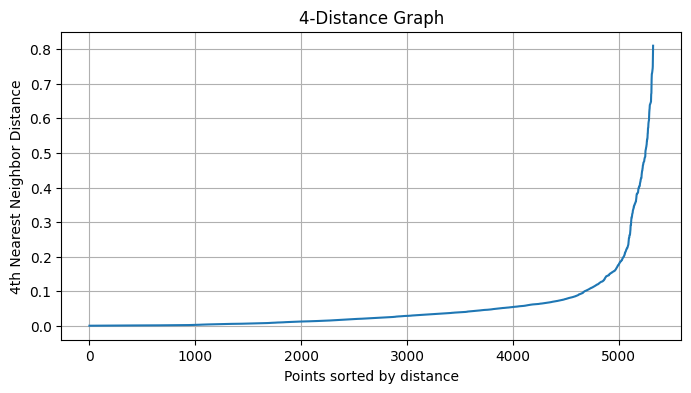

Cluster Compactness: 0.21302711963653564
Cluster Separation: 4.755855560302734
Noise Ratio: 0.048459804658151764
DBSCAN found 2 clusters.


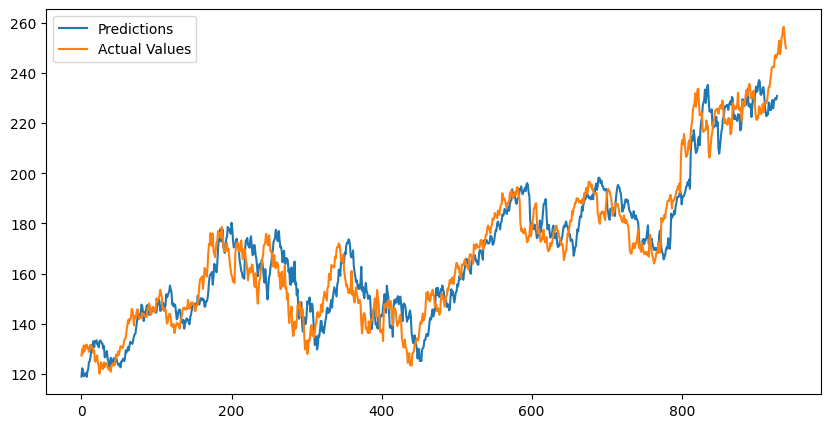

Sample predictions: [228.9762  229.2348  229.95123 229.47327 230.81685]
Sample true values: tensor([[257.5787],
        [258.3967],
        [254.9749],
        [251.5931],
        [249.8174]])
RMSE: 0.0688
R^2: 0.8931
Number of Rules (Clusters): 2


In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    X, y = preprocess_data(ticker="AAPL", start_date="2000-01-01", end_date="2025-01-01", n_past=13, n_lookahead=13) # Returns results for t+n_lookahead, given a sliding window input of length n_past

    y = y.flatten()

    # Split into train and test sets
    split_idx = int(0.85 * len(X))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Train the model
    trained_model, rmse, r2, n_clusters = train_model(
        X_train, y_train, X_test, y_test, eps=0.2, min_samples=4, epochs=50, lr=0.001
    )

    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"Number of Rules (Clusters): {n_clusters}")

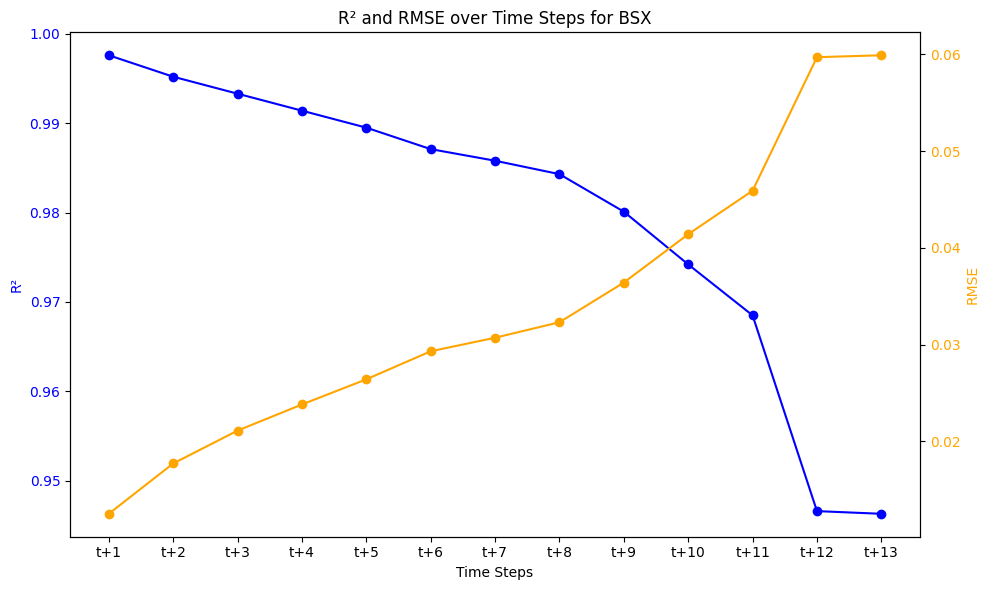

In [ ]:
r2_list_ge = [0.9982, 0.9967, 0.9953, 0.9936, 0.9921, 0.9908, 0.9893, 0.9875, 0.9867, 0.9849, 0.9844, 0.9828, 0.9801]
rmse_list_ge = [0.0120, 0.0161, 0.0193, 0.0224, 0.0249, 0.0269, 0.0290, 0.0313, 0.0323, 0.0345, 0.0350, 0.0368, 0.0396]

r2_list_ko = [0.9892, 0.9780, 0.9667, 0.9561, 0.9460, 0.9346, 0.9242, 0.9132, 0.9023, 0.8905, 0.8774, 0.8693, 0.8554]
rmse_list_ko = [0.0223, 0.0317, 0.0390, 0.0448, 0.0497, 0.0546, 0.0588, 0.0629, 0.0668, 0.0707, 0.0748, 0.0772, 0.0812]

r2_list_bsx = [0.9976, 0.9952, 0.9933, 0.9914, 0.9895, 0.9871, 0.9858, 0.9843, 0.9801, 0.9742, 0.9685, 0.9466, 0.9463]
rmse_list_bsx = [0.0125, 0.0177, 0.0211, 0.0238, 0.0264, 0.0293, 0.0307, 0.0323, 0.0364, 0.0414, 0.0459, 0.0597, 0.0599]

r2_list_xom = [0.9955, 0.9910, 0.9865, 0.9826, 0.9783, 0.9744, 0.9694, 0.9658, 0.9642, 0.9605, 0.9547, 0.9524, 0.9474]
rmse_list_xom = [0.0196, 0.0280, 0.0342, 0.0387, 0.0432, 0.0470, 0.0514, 0.0543, 0.0555, 0.0583, 0.0624, 0.0640, 0.0673]

r2_list_jpm = [0.9953, 0.9907, 0.9862, 0.9816, 0.9771, 0.9725, 0.9682, 0.9635, 0.9596, 0.9551, 0.9515, 0.9468, 0.9441]
rmse_list_jpm = [0.0152, 0.0213, 0.0260, 0.0301, 0.0335, 0.0368, 0.0395, 0.0423, 0.0446, 0.0470, 0.0490, 0.0513, 0.0526]

r2_list_aapl = [0.9913, 0.9822, 0.9741, 0.9660, 0.9584, 0.9501, 0.9411, 0.9329, 0.9249, 0.9162, 0.9081, 0.9007, 0.8920]
rmse_list_aapl = [0.0195, 0.0279, 0.0337, 0.0387, 0.0428, 0.0468, 0.0509, 0.0543, 0.0575, 0.0607, 0.0638, 0.0663, 0.0691]

# Create plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

x_labels = [f"t+{i+1}" for i in range(len(r2_list_bsx))] # Change r2_list according to ticker

# Plot R2 on the left y-axis
ax1.plot(x_labels, r2_list_bsx, label='R²', color='blue', marker='o')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('R²', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for RMSE
ax2 = ax1.twinx()
ax2.plot(x_labels, rmse_list_bsx, label='RMSE', color='orange', marker='o')
ax2.set_ylabel('RMSE', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('R² and RMSE over Time Steps for BSX')
fig.tight_layout()

plt.show()